# Boston House price Prediction

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
print(os.listdir("../input"))
# Any results you write to the current directory are saved as output.
from pandas import read_csv
#Lets load the dataset and sample some
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data = read_csv('../input/housing.csv', header=None, delimiter=r"\s+", names=column_names)
print(data.head(5))

['housing.csv']
      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  


In [3]:
# Dimension of the dataset
print(np.shape(data))

(506, 14)


In [4]:
# Let's summarize the data to see the distribution of data
print(data.describe())

             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677082   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.1057

From get-go,  two data coulmns show interesting summeries. They are : ZN (proportion of residential land zoned for lots over 25,000 sq.ft.)  with 0 for 25th, 50th percentiles. Second, CHAS: Charles River dummy variable (1 if tract bounds river; 0 otherwise) with 0 for 25th, 50th and 75th percentiles. These summeries are understandable as both variables are conditional + categorical variables. First assumption would be that these coulms may not be useful in regression task such as predicting MEDV (Median value of owner-occupied homes).

Another interesing fact on the dataset is the max value of MEDV. From the original data description, it says: Variable #14 seems to be censored at 50.00 (corresponding to a median price of $50,000). Based on that, values above 50.00 may not help to predict MEDV. Let's plot the dataset and see interesting trends/stats.

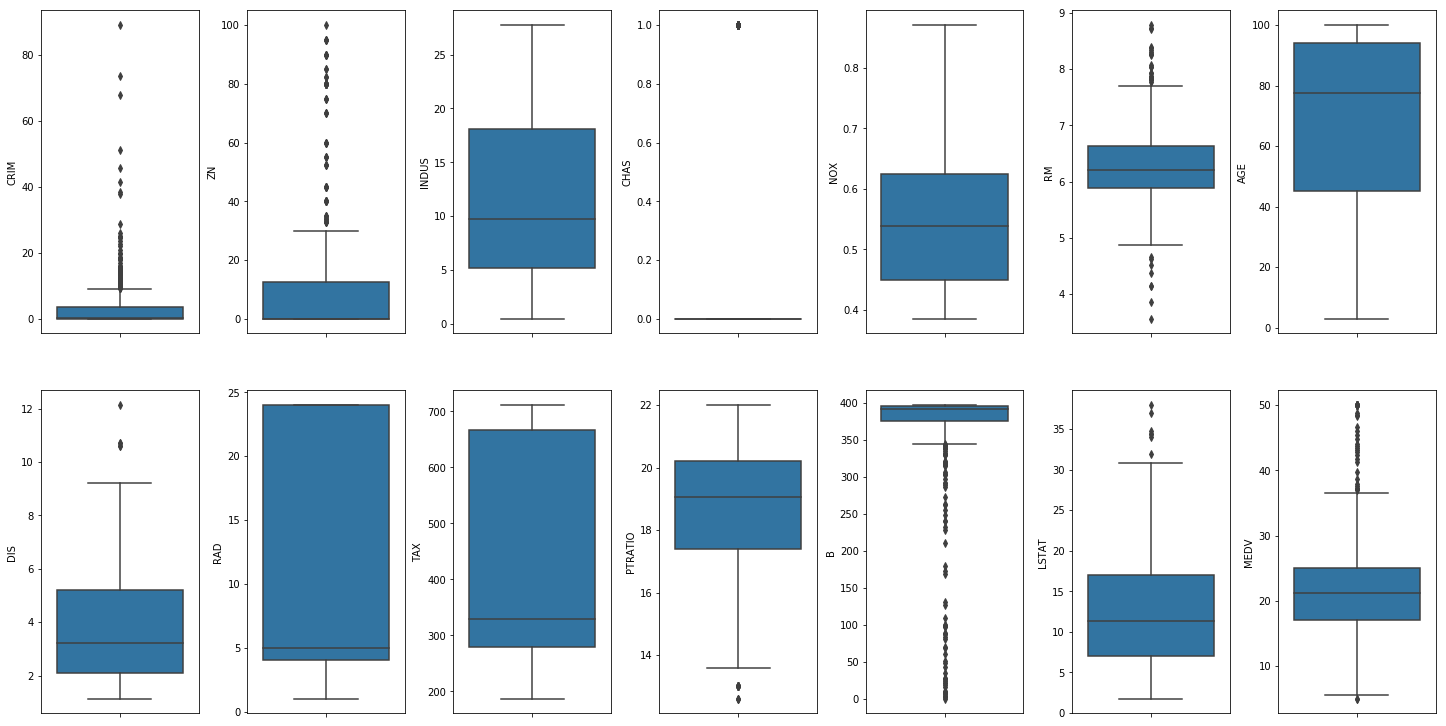

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.boxplot(y=k, data=data, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Columns like CRIM, ZN, RM, B seems to have outliers. Let's see the outliers percentage in every column.

In [6]:
    for k, v in data.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(data)[0]
        print("Column %s outliers = %.2f%%" % (k, perc))
    
    

Column CRIM outliers = 13.04%
Column ZN outliers = 13.44%
Column INDUS outliers = 0.00%
Column CHAS outliers = 100.00%
Column NOX outliers = 0.00%
Column RM outliers = 5.93%
Column AGE outliers = 0.00%
Column DIS outliers = 0.99%
Column RAD outliers = 0.00%
Column TAX outliers = 0.00%
Column PTRATIO outliers = 2.96%
Column B outliers = 15.22%
Column LSTAT outliers = 1.38%
Column MEDV outliers = 7.91%


Let's remove MEDV outliers (MEDV = 50.0) before plotting more distributions

In [7]:
data = data[~(data['MEDV'] >= 50.0)]
print(np.shape(data))

(490, 14)


Let's see how these features plus MEDV distributions looks like

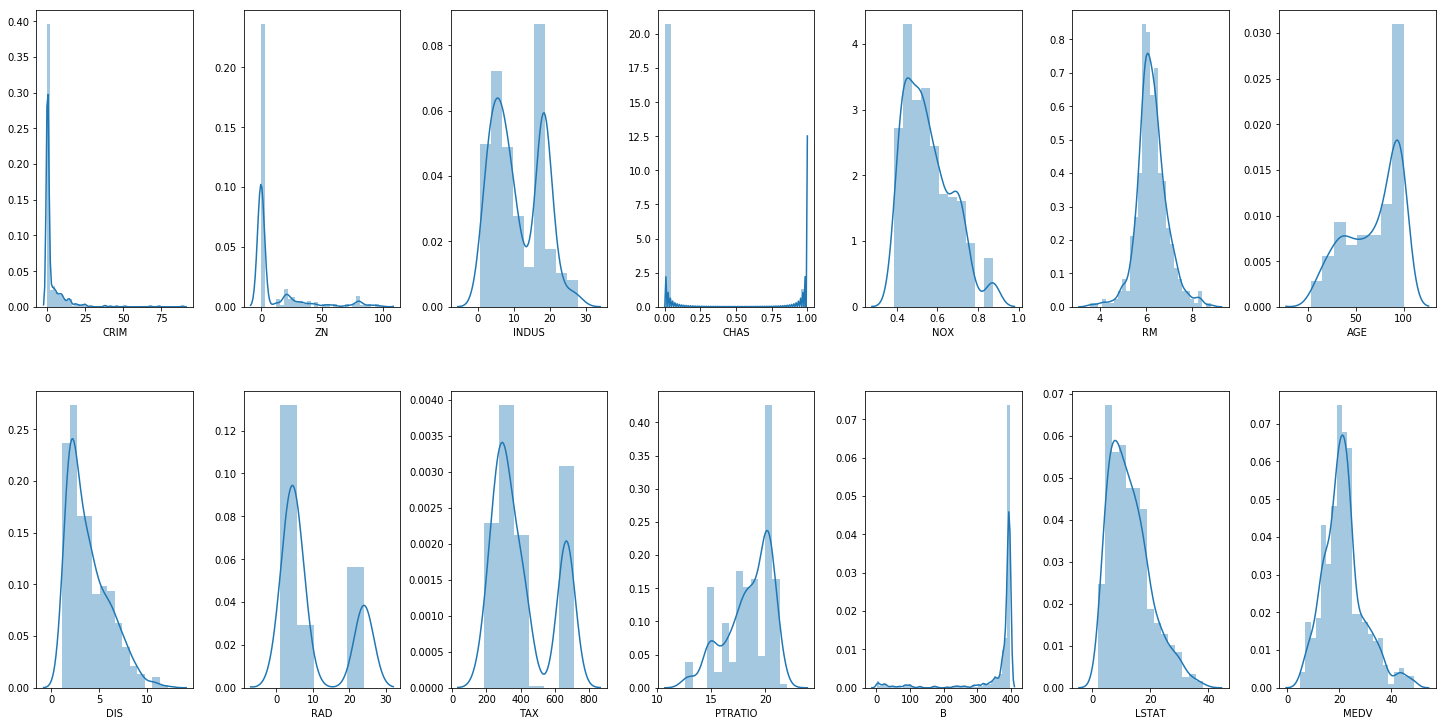

In [8]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

The histogram also shows that columns CRIM, ZN, B has highly skewed distributions. Also MEDV looks to have a normal distribution (the predictions) and other colums seem to have norma or bimodel ditribution of data except CHAS (which is a discrete variable).

Now let's plot the pairwise  correlation on data.

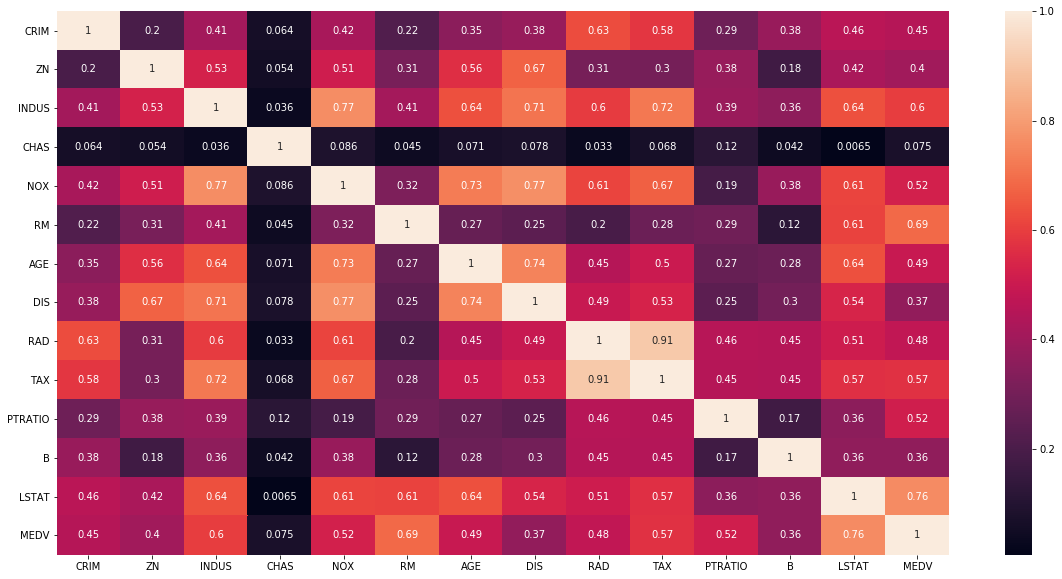

In [9]:
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr().abs(),  annot=True)

From correlation matrix, we see TAX and RAD are highly correlated features. The columns LSTAT, INDUS, RM, TAX, NOX, PTRAIO has a correlation score above 0.5 with MEDV which is a good indication of using as predictors. Let's plot these columns against MEDV. 

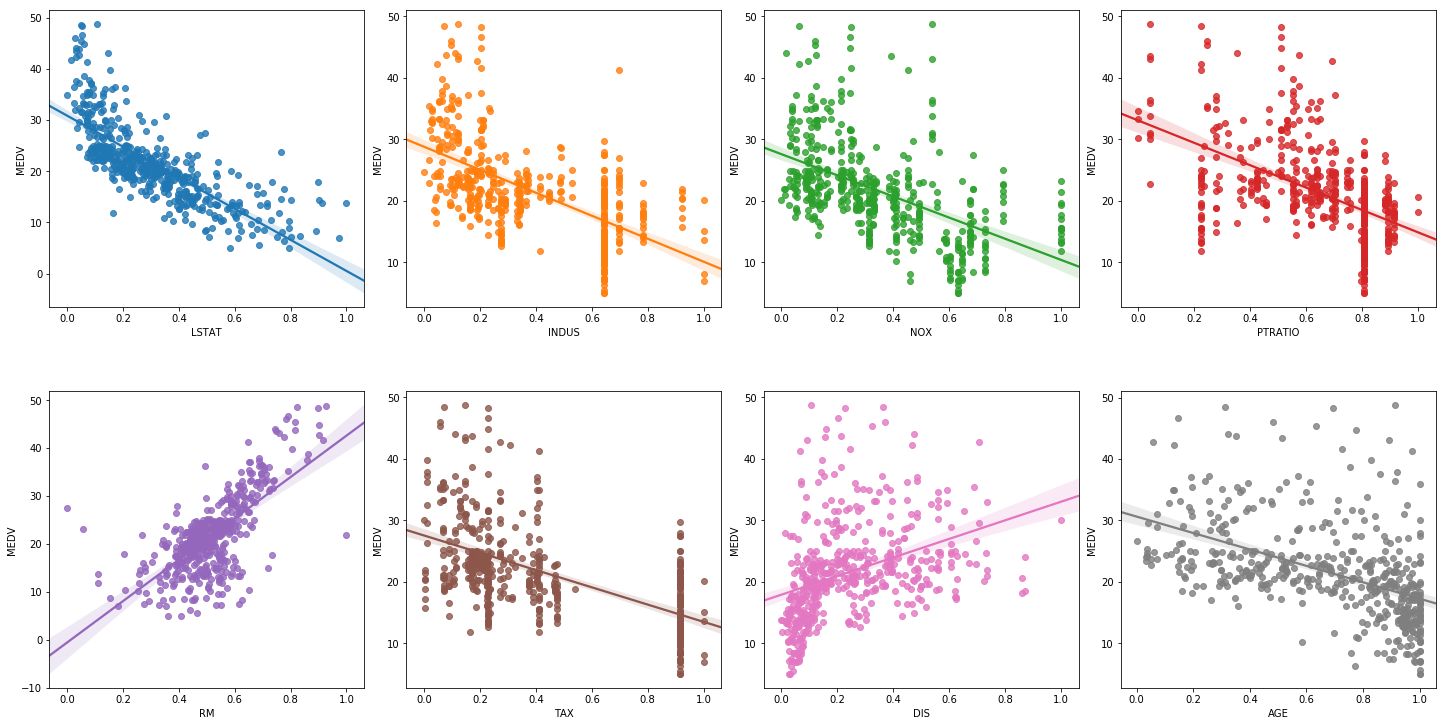

In [14]:
from sklearn import preprocessing
# Let's scale the columns before plotting them against MEDV
min_max_scaler = preprocessing.MinMaxScaler()
column_sels = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']
x = data.loc[:,column_sels]
y = data['MEDV']
x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=column_sels)
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for i, k in enumerate(column_sels):
    sns.regplot(y=y, x=x[k], ax=axs[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)


So with these analsis, we may try predict MEDV with 'LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE' features. Let's try to remove the skewness of the data trough log transformation.



In [17]:
y =  np.log1p(y)
for col in x.columns:
    if np.abs(x[col].skew()) > 0.3:
        x[col] = np.log1p(x[col])

Let's try Linear, Ridge Regression on dataset first.

In [18]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np

l_regression = linear_model.LinearRegression()
kf = KFold(n_splits=10)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scores = cross_val_score(l_regression, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

scores_map = {}
scores_map['LinearRegression'] = scores
l_ridge = linear_model.Ridge()
scores = cross_val_score(l_ridge, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['Ridge'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

# Lets try polinomial regression with L2 with degree for the best fit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
#for degree in range(2, 6):
#    model = make_pipeline(PolynomialFeatures(degree=degree), linear_model.Ridge())
#    scores = cross_val_score(model, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
#    print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
model = make_pipeline(PolynomialFeatures(degree=3), linear_model.Ridge())
scores = cross_val_score(model, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['PolyRidge'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))


MSE: -0.00 (+/- 0.00)
MSE: -0.00 (+/- 0.00)
MSE: -0.00 (+/- 0.00)


The Liner Regression with and without L2 regularization does not make significant difference is MSE score. However polynomial regression with degree=3 has a better MSE. Let's try some non prametric regression techniques: SVR with kernal rbf, DecisionTreeRegressor, KNeighborsRegressor etc.

In [109]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
#grid_sv = GridSearchCV(svr_rbf, cv=kf, param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 5)}, scoring='neg_mean_squared_error')
#grid_sv.fit(x_scaled, y)
#print("Best classifier :", grid_sv.best_estimator_)
scores = cross_val_score(svr_rbf, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['SVR'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))


In [110]:
from sklearn.tree import DecisionTreeRegressor

desc_tr = DecisionTreeRegressor(max_depth=5)
#grid_sv = GridSearchCV(desc_tr, cv=kf, param_grid={"max_depth" : [1, 2, 3, 4, 5, 6, 7]}, scoring='neg_mean_squared_error')
#grid_sv.fit(x_scaled, y)
#print("Best classifier :", grid_sv.best_estimator_)
scores = cross_val_score(desc_tr, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['DecisionTreeRegressor'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

In [111]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=7)
scores = cross_val_score(knn, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['KNeighborsRegressor'] = scores
#grid_sv = GridSearchCV(knn, cv=kf, param_grid={"n_neighbors" : [2, 3, 4, 5, 6, 7]}, scoring='neg_mean_squared_error')
#grid_sv.fit(x_scaled, y)
#print("Best classifier :", grid_sv.best_estimator_)
print("KNN Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

Compared to three models which are shosen through grid search, SVR performes better. Let's try an ensemble method finally.

In [112]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(alpha=0.9,learning_rate=0.05, max_depth=2, min_samples_leaf=5, min_samples_split=2, n_estimators=100, random_state=30)
#param_grid={'n_estimators':[100, 200], 'learning_rate': [0.1,0.05,0.02], 'max_depth':[2, 4,6], 'min_samples_leaf':[3,5,9]}
#grid_sv = GridSearchCV(gbr, cv=kf, param_grid=param_grid, scoring='neg_mean_squared_error')
#grid_sv.fit(x_scaled, y)
#print("Best classifier :", grid_sv.best_estimator_)
scores = cross_val_score(gbr, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['GradientBoostingRegressor'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))


Let's plot k-fold results to see which model has better distribution of results. Let's have a look at the MSE distribution of these models with k-fold=10

In [113]:
plt.figure(figsize=(20, 10))
scores_map = pd.DataFrame(scores_map)
sns.boxplot(data=scores_map)

The models SVR and GradientBoostingRegressor show better performance with -11.62 (+/- 5.91) and -12.39 (+/- 5.86).

This is my first kernel and thanks to https://www.kaggle.com/vikrishnan for the dataset and the well writtten kernel that provdies great pointers into this dataset.